# Detecção de fraude em transações com cartão de crédito 

Com o crescente número de transações financeiras realizadas tanto por cartão de crédito quanto por meio digitais tais como celulares e computadores, também passa a crescer o número de fraudes nessas operações. Desse modo, o prejuízo financeiro para as empresas que operam nessas transações vêm aumentando significativamente ao longo dos últimos anos, como pode ser visto no seguinte estudo


é de suma importância para as empresas que operam as transações 



Nesse notebook iremos explorar um dataset fornecido pelo Kaggle em https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv, onde se encontram um 


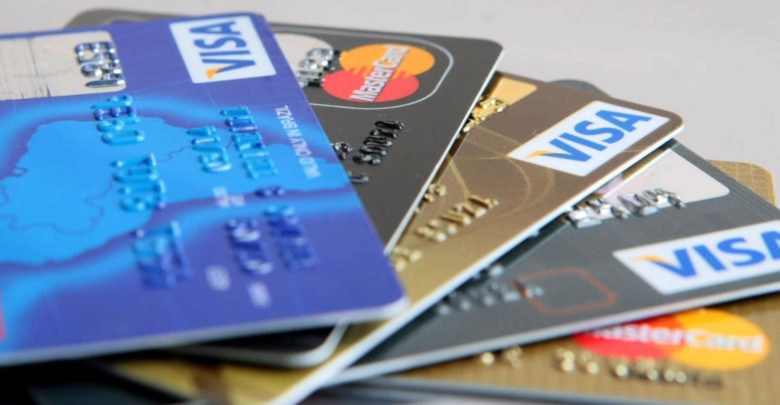


Nesse notebook iremos explorar um dataset fornecido pelo Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv) cujo objetivo será detectar quais transações são fraudulentas e quais são genuínas.


(Inserir uma apresentação mais bonita aqui)

# Bibliotecas 

In [175]:
import os
import warnings

# Importando Pandas
import pandas as pd

# Importando NumPy
import numpy as np
from numpy import where

# SciPy
from scipy import stats
import statsmodels.api as sm

# Importando bibliotecas para criação de modelos

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import skopt 
from skopt import BayesSearchCV
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, auc 
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.feature_selection import mutual_info_classif

# Biblioteca para lidar com o desbalanceamento dos dados
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


from collections import Counter

import shap

# Bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Funções Utilizadas

In [64]:
# Função que avalia várias métricas no modelo
def evaluate_model(y_true, y_pred, y_pred_proba, model):
    '''A função tem como objetivo avaliar o modelo em diversas métricas que desejarmos. Ela recebe X_true onde iremos obter 
    os valores previstos, recebe os valores reais com os quais queremos comparar a nossa performance e recebe o modelo. 
    Os resultados ficam armazenados em score e a função não retorna nada.'''
    
    # Calcula a F2-score:
    F2 = fbeta_score(y_true, y_pred, beta=2)
    
    # Calcula a precision:
    score_pr = precision_score(y_true, y_pred, zero_division = 0)
    
    # Calcula o recall:
    score_rec = recall_score(y_true, y_pred, zero_division = 0)
    
    # Calcula a área sob a curva Precision-Recall:
    #y_pred_proba = model.predict_proba(X_true)[:, 1] # Calcula as previsões como probabilidades
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba) # Calcula a curva Precision-Recall
    auc_prcurve = average_precision_score(y_true, y_pred_proba) # Calcula a área sob a curva Precision-Recall
    
    # Score das métricas
    score = (F2, score_pr, score_rec, auc_prcurve)
    
    print(f'Avaliando o modelo de base para a métrica F2 : {score[0]:.2f}')
    print(f'Avaliando o modelo de base para a métrica Precision : {score[1]:.2f}')
    print(f'Avaliando o modelo de base para a métrica Recall : {score[2]:.2f}')
    print(f'Avaliando o modelo de base para a métrica AUC-PR : {score[3]:.2f}')
    

# Função que irá plotar um heatmap da matriz de confusão do modelo e sua respectiva curva Precision-Recall
def plot_confusion_PR(y_true, y_pred, y_pred_proba, model):
    '''A função tem como objetivo plotar um heatmap da matriz de confusão do modelo e também plotar sua curva Precision-Recall.
    Recebe como parâmetros os dados X_true que são usados na predição e os dados reais a serem avaliados, y_true. Não retorna
    nada.'''
    
    # Calcula a matriz de confusão do modelo
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Inserir um label na matriz de confusão contendo o nome de cada elemento, a sua quantidade e porcentagem
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    # Plotar o heatmap da matriz de confusão lado a lado com a PR-curve
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    # Construindo o heatmap da matriz de confusão
    df_conf_matrix = pd.DataFrame(conf_matrix, columns=['Fraudulent', 'Genuine'], index = ['Fraudulent', 'Genuine']).T
    sns.heatmap(df_conf_matrix, annot=labels, fmt='', cmap='RdYlGn', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    
    # Constrói a curva Precision-Recall:
    #y_pred_proba = model.predict_proba(X_true)[:, 1] # Calcula as previsões como probabilidades
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba) # Calcula a curva Precision-Recall
    ax[1].plot(recall, precision, color = 'g') # Plot da curva Precision - Recall
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    plt.show()
    plt.clf() 

## 1) Pré-processamento e primeiras observações sobre o dataset

Nosso primeiro passo após carregar o dataset, será explorar suas características mais gerais, tais como o número de linhas e colunas, o tipo de dados presentes em cada uma dessas colunas, se existem missing values, valores duplicados, etc. É importante para sabermos que tipo de dados estamos lidando.

In [3]:
# Importando a biblioteca Pandas
import pandas as pd 

In [4]:
# Carregando o dataset como um dataframe a partir do arquivo .csv
credit_card = pd.read_csv('creditcard.csv')

In [5]:
# Primeiras 5 linhas
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Informações sobre o dataset
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# Descrição do dataset
credit_card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


* O dataset possui 31 colunas e a última, denominada "Class", será o alvo. Cada evento é representado por uma linha e temos 284807 delas. Não há a presença de dados do tipo "objeto" no nosso dataset - todos dados são do tipo float ou int;


* Uma informação importante fornecida na descrição do desafio no Kaggle é a de que todas variáveis Vi estão dessa forma pois já foram submetidas a uma PCA de tal modo a anonimizar as informações das transações. Com isso, somente duas variáveis ainda estão no seu formato original, que são as variáveis "Time" e "Amount".


* Uma observação importante é que na coluna "Amount" há uma variação grande entre o valor mínimo e máximo presentes nela (se comparado a diferença entre mínimo e máximo das outras variáveis), a saber, o valor mínimo é 0 e o valor máximo é 25691.16. É possível que esse valor alto seja um outlier nessa coluna, uma vez que ela corresponde a quantidade de dinheiro transacionado. A parte desse possível outlier, será necessário uma normalização dessa coluna de tal modo que todos os dados mantenham um range razoável de variação.

Vamos verificar se existem missing values e valores duplicados no nosso dataset.

In [8]:
# Verificando a existência de missing values e de valores duplicados
print("Número de missing values encontrados:", credit_card.isnull().sum().sum())

# Formato original do dataset
original_form = credit_card.shape[0]

# Removendo os valores duplicados
credit_card.drop_duplicates(inplace=True)

# Formato após a remoção
after_form = credit_card.shape[0]

# Número de valores duplicados removidos
print("Número de valores duplicados removidos:", original_form - after_form )

Número de missing values encontrados: 0
Número de valores duplicados removidos: 1081


* Como vemos, felizmente não existem missing values nesse dataset. Quanto aos valores duplicados, foram removidos 1081 deles.

Vamos ver agora o quão desbalanceado é o nosso conjunto de dados. É esperado que ele seja muito desbalanceado uma vez que, em situações normais, o número de transações genuínas (classificadas como 0) é muito superior ao número de transações fraudulentas (classificadas como 1).

In [9]:
# Porcentagem de transações genuínas e fraudulentas no dataset
print(credit_card['Class'].value_counts(normalize = True))

0    0.998333
1    0.001667
Name: Class, dtype: float64


Text(0.5, 1.0, 'Number of genuine and fraudulent transactions \n (0: Genuine | 1: Fraudulent)')

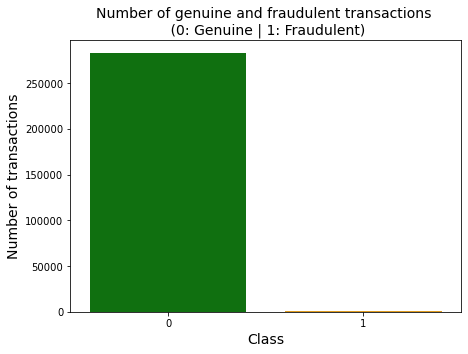

In [10]:
# Visualizando a proporção entre transações genuínas e fraudulentas
colors = ["Green", "Orange"]
plt.figure(figsize=(7,5))
ax = sns.countplot(x='Class', data=credit_card, palette=colors)
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Number of transactions', fontsize=14)
plt.title('Number of genuine and fraudulent transactions \n (0: Genuine | 1: Fraudulent)', fontsize=14)

* De fato o conjunto é bastante desbalanceado. Cerca de ~99,8% dos valores no target são transações genuínas e somente ~0,17% são transações fraudulentas. Quando formos construir os modelos de previsão teremos que lidar com esse desbalanceamento. 

## 2) Análise Exploratória dos Dados

Vamos dar início a uma análise exploratória dos nossos dados. Como as variáveis do problema são todas categorizadas em termos de V1, V2, ..., V28, não temos como ter um "feeling" sobre os dados que estamos lidando de antemão. Serão necessários alguns procedimentos para obter alguma intuição. Dividiremos nossa análise em alguns passos e perguntas a serem respondidas. São eles:


* As variáveis seguem uma distribuição normal? É importante essa análise uma vez que alguns métodos lineares como, por exemplo, regressão logística, fazem uso dessa hipótese. Começaremos com uma análise qualitativa visual por meio de um gráfico Q-Q e, após isso, uma análise quantitativa por meio de um teste de Kolmogorov-Smirnov, que nos fornecerá tanto uma estatística quanto o valor-p associado a cada variável;


* Qual a correlação entre as variáveis do problema? Qual a correlação entre elas e a variável alvo? Para encontramos essas correlações iremos realizar um teste de Pearson e um teste de Spearman. A ideia aqui é procurar por um subconjunto de variáveis que possam ter um impacto maior na determinação da transação ser fraudulenta ou não.


* Por fim, iremos analisar a relação mútua entre as variáveis do problema e o alvo. Essa observação é interessante pois medirá a dependência das variáveis com relação ao alvo e, com isso, podemos saber qual variável é mais dependente - no sentido de ganho de informação. 

Antes de darmos início a análise propriamente, vamos normalizar a variável "Amount" como comentamos antes. Na sequência iremos observar a distribuição da variável "Time" com intuito de procurar por algum padrão nela. 

In [11]:
# Observando a variância das variáveis do dataset
credit_card.iloc[:, :30].var()

Time      2.254450e+09
V1        3.794806e+00
V2        2.711631e+00
V3        2.276121e+00
V4        1.999916e+00
V5        1.896152e+00
V6        1.774039e+00
V7        1.507159e+00
V8        1.390169e+00
V9        1.200104e+00
V10       1.158653e+00
V11       1.037791e+00
V12       9.893773e-01
V13       9.908802e-01
V14       9.067136e-01
V15       8.370304e-01
V16       7.633453e-01
V17       7.098186e-01
V18       7.012011e-01
V19       6.615847e-01
V20       5.928757e-01
V21       5.240448e-01
V22       5.249734e-01
V23       3.890047e-01
V24       3.667837e-01
V25       2.716706e-01
V26       2.323750e-01
V27       1.566132e-01
V28       1.076015e-01
Amount    6.269988e+04
dtype: float64

Com exceção da variável "Time", que iremos trabalhar separadamente, a variável "Amount" possui 4 ordens de grandeza a mais na variância em comparação as variáveis $V_{i}$. Um bom e simples método para normalizá-la é usar o logaritmo. Vamos fazer isso.

In [12]:
# Normalizando a variável "Amount" usando logaritmo
credit_card['Amount'] = np.log(credit_card.Amount + 0.01)

Agora vamos plotar a distribuição da variável "Time", separando por classes, para ver se há algum padrão que possa ser identificado. 

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


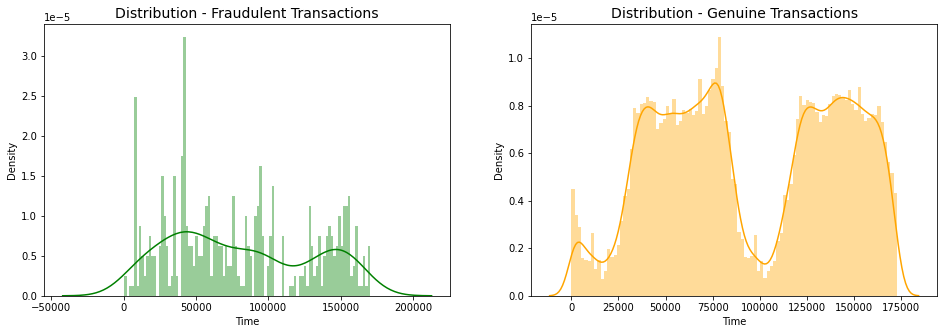

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

sns.distplot(credit_card[(credit_card['Class'] == 1)]['Time'], bins=100, color='green', ax=axes[0])
axes[0].set_title("Distribution - Fraudulent Transactions", fontsize = 14)

sns.distplot(credit_card[(credit_card['Class'] == 0)]['Time'], bins=100, color='orange', ax=axes[1])
axes[1].set_title("Distribution - Genuine Transactions", fontsize = 14)

plt.show()

Como podemos perceber, existem dois picos bem nítidos na distribuição das transações genuínas e esse intervalo de tempo é o mesmo para os picos das transações fraudulentas, com certa aproximação. Como dito pela descrição do problema no Kaggle, esses dados foram coletados durante dois dias de transações, o que provavelmente explique a presença de dois picos especificamente. É possível notar, pela distribuição das transações genuínas, que a diferença entre os dois picos é de 75000 segundos, que é a mesma diferença entre o tempo inicial e o primeiro pico - ou seja, esses picos correspondem a um certo período do dia onde ocorrem mais transações.

Embora a variável "Time" possa ser usada para se analisar há alguma relação maior entre o horário das fraudes, não iremos lidar com ela no nosso trabalho. Vamos tratar o problema de classificação binária excluindo essa variável.

In [14]:
# Excluindo a variável "Time" do dataset
credit_card.drop("Time", axis=1, inplace=True)

Nosso próximo passo será definir as nossas variáveis independentes ("features") e qual será a variável alvo ("target").

In [16]:
# Definindo as variáveis independentes ("features") e a variável alvo ("target")
target = credit_card['Class']
variables = credit_card.loc[:, credit_card.columns != 'Class']

Agora iremos realizar uma análise exploratória dos dados de modo a responder as perguntas propostas no início.

### 2.1 As variáveis seguem uma distribuição normal? O gráfico Q-Q e o teste de Kolmogorov-Smirnov

Nosso primeiro objetivo será investigar se nossas variáveis seguem uma distribuição normal ou não. Como dissemos, essa verificação é importante pois métodos lineares como Regressão Logística (que usaremos) fazem uso dessa hipótese para serem implementados. 


Vamos iniciar pela análise qualitativa. O gráfico Q-Q é uma maneira interessante e prática de, visualmente, observar se as variáveis do problema seguem uma distribuição normal. Esse tipo de gráfico descreve na mesma imagem duas distribuições a serem comparadas. Expressando a distribuição normal (ideal) por meio de uma reta, os nossos dados são distribuídos nessa figura de tal modo que, se eles seguem a distribuição normal, eles devem se distribuir exatamente em cima dessa reta ideal.

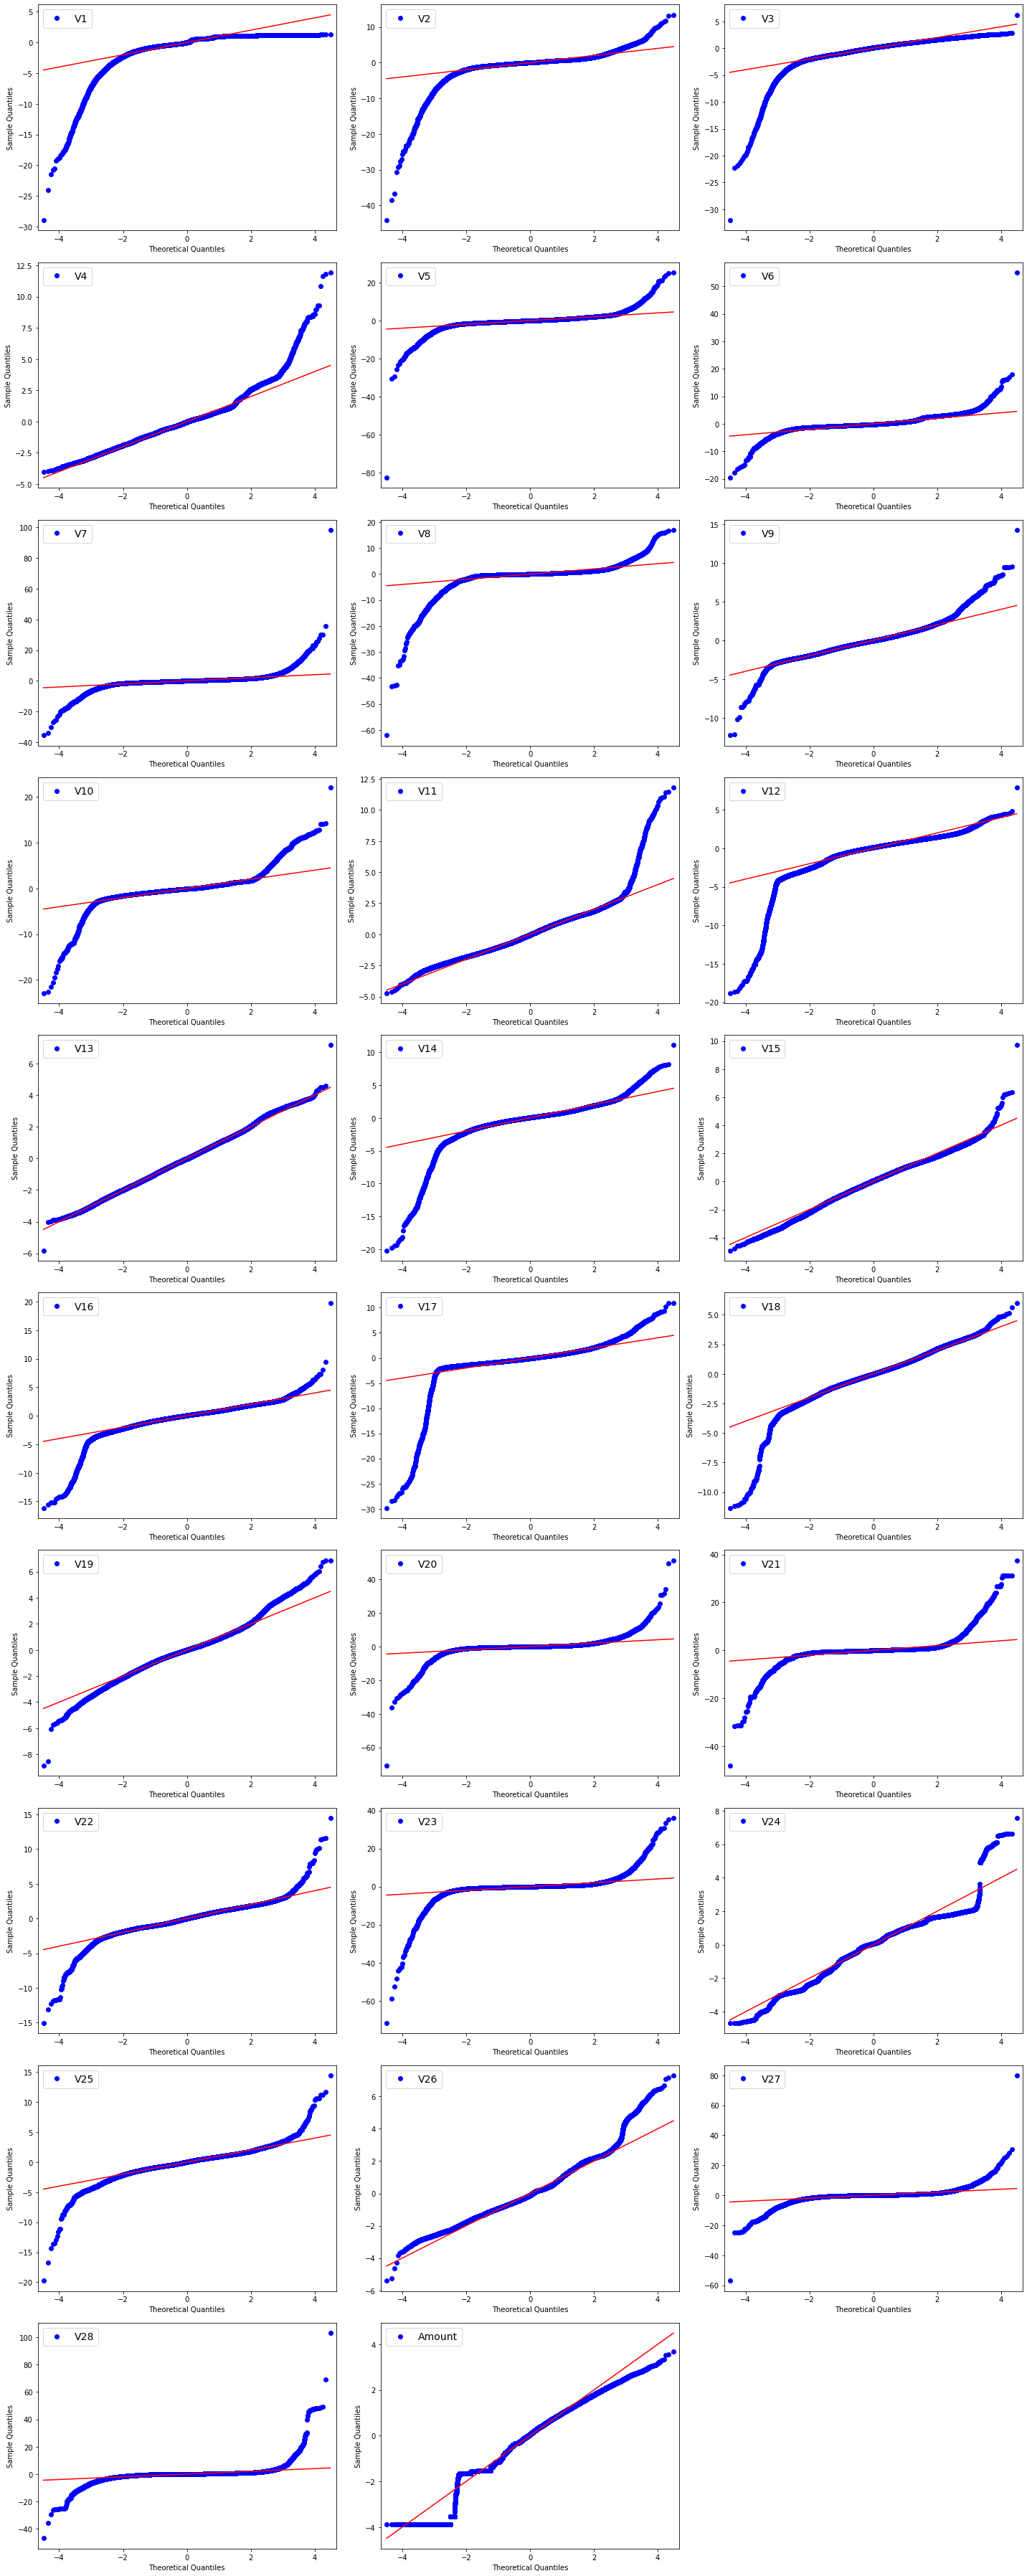

In [20]:
# Implementando o gráfico-QQ
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50))
ax = axes.flatten()
for i, col in enumerate(variables.columns.values[:29]):
    qq=sm.qqplot(variables[col], fit = True, line='s', ax=ax[i])
    ax[i].legend([col], fontsize = 14)
    
plt.delaxes(ax[29])   
plt.tight_layout()
plt.show() 

Observando esse gráfico Q-Q percebe-se que as variáveis não seguem uma distribuição normal. Alguns comportamentos são típicos de distribuições que sofrem de skewed e outras são de distribuições cujo pico é muito acumulado no centro da distribuição. Por exemplo, a variável "V1" é uma distribuição "skewed left" e variável "V2" é muito acumulada no centro. 


Vamos checar essa análise por meio de um resultado estatístico mais robusto. Iremos realizar um teste de Kolmogorov-Smirnov. Esse é um bom teste para analisar se uma distribuição é normal ou não. Basicamente ele funciona do seguinte modo para testar normalidade: 1) constrói a CDF (cumulative density function) - que nada mais é do que uma curva descrevendo qual a fração dos dados que são menores ou iguais aos valores correspondentes no eixo horizontal - de uma distribuição normal; 2) constrói a ECDF (empirical cumulative density function) dos dados que queremos explorar o comportamento - ECDF é a mesma ideia da CDF porém realizada com a amostra empírica; 3) O teste é realizado encontrando a maior distância vertical entre as duas curvas. Esse valor é chamado de **estatística K-S** e, quanto maior ele for, indica que a distribuição é menos consistente com a distribuição de hipótese (no nosso caso a distribuição normal). 


O teste também nos fornecerá o valor-p associado. A hipótese nula aqui é a de que as duas amostras (distribuição normal e a distribuição empírica dos nossos dados) seguem da mesma distribuição. Vamos rejeitar essa hipótese caso o valor-p seja menor do 0.05. 

In [21]:
# Realizando o teste de Kolmogorov-Smirnov
for i, col in enumerate(variables.columns.values[:29]):
    print(col, "Statistic:%.2f" %(np.round(stats.kstest(variables[col], 'norm'),3)[0]) , "p-value: %.2f" %(np.round(stats.kstest(variables[col], 'norm'),3)[1]) ) 
    

V1 Statistic:0.25 p-value: 0.00
V2 Statistic:0.04 p-value: 0.00
V3 Statistic:0.10 p-value: 0.00
V4 Statistic:0.06 p-value: 0.00
V5 Statistic:0.03 p-value: 0.00
V6 Statistic:0.12 p-value: 0.00
V7 Statistic:0.05 p-value: 0.00
V8 Statistic:0.22 p-value: 0.00
V9 Statistic:0.03 p-value: 0.00
V10 Statistic:0.09 p-value: 0.00
V11 Statistic:0.03 p-value: 0.00
V12 Statistic:0.09 p-value: 0.00
V13 Statistic:0.01 p-value: 0.00
V14 Statistic:0.09 p-value: 0.00
V15 Statistic:0.04 p-value: 0.00
V16 Statistic:0.07 p-value: 0.00
V17 Statistic:0.11 p-value: 0.00
V18 Statistic:0.07 p-value: 0.00
V19 Statistic:0.08 p-value: 0.00
V20 Statistic:0.25 p-value: 0.00
V21 Statistic:0.26 p-value: 0.00
V22 Statistic:0.10 p-value: 0.00
V23 Statistic:0.28 p-value: 0.00
V24 Statistic:0.15 p-value: 0.00
V25 Statistic:0.18 p-value: 0.00
V26 Statistic:0.19 p-value: 0.00
V27 Statistic:0.32 p-value: 0.00
V28 Statistic:0.35 p-value: 0.00
Amount Statistic:0.71 p-value: 0.00


In [22]:
# Inicializando uma lista com os resultados do teste KS
data = [{'V1': 0.25, 'V2':0.04, 'V3':0.10, 'V4':0.06, 'V5':0.03, 'V6':0.12, 'V7':0.05, 'V8':0.22, 'V9':0.03, 'V10':0.09, 'V11':0.03
        ,'V12':0.09, 'V13':0.01, 'V14':0.09, 'V15':0.04, 'V16':0.07, 'V17':0.11, 'V18':0.07, 'V19':0.08, 'V20':0.25, 'V21':0.26
        ,'V22':0.10, 'V23':0.28, 'V24':0.15, 'V25':0.18, 'V26':0.19, 'V27':0.32, 'V28':0.35, 'Amount':0.83}, 
        {'V1': True, 'V2':True, 'V3':True, 'V4':True, 'V5':True, 'V6':True, 'V7':True, 'V8':True, 'V9':True, 'V10':True, 'V11':True
        ,'V12':True, 'V13':True, 'V14':True, 'V15':True, 'V16':True, 'V17':True, 'V18':True, 'V19':True, 'V20':True, 'V21':True
        ,'V22':True, 'V23':True, 'V24':True, 'V25':True, 'V26':True, 'V27':True, 'V28':True, 'Amount':True}]
  
# Criando um dataframe a partir da lista acima para uma melhor visualização do resultado
df = pd.DataFrame(data, index =['KS-Statistic', 'p-value (< 0.05?)'])
df

  

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
KS-Statistic,0.25,0.04,0.1,0.06,0.03,0.12,0.05,0.22,0.03,0.09,...,0.25,0.26,0.1,0.28,0.15,0.18,0.19,0.32,0.35,0.83
p-value (< 0.05?),True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


Por meio do teste K-S confirmamos o que havíamos observado através da análise qualitativa nos gráficos Q-Q. De fato nossos dados não seguem uma distribuição normal. Vamos procurar tentar deixá-los mais próximos de uma distribuição normal antes de realizarmos uma Regressão Logística mais a frente. 

### 2.2 Estudando a correlação e a informação mútua entre as variáveis

Vamos analisar a correlação entre as variáveis. O método mais comum para realizar isso é por meio de uma matriz de correlação onde se usa a correlação de Pearson como padrão. A correlação de Pearson mede uma relação linear entre as variáveis. Se a variáveis a serem exploradas seguem ambas uma distribuição normal, o método se torna mais robusto e completo. No nosso caso, como vimos, elas não se distribuem normalmente, o que acaba enfraquecendo o método como análise. Todavia, iremos plotar a matriz de correlação usando esse método somente com o propósito de explorar se é possível achar alguma variável que tenha uma maior influência no alvo e, se esse for o caso, vamos fazer uma boxplot dessa variável para confirmar ou não isso. 


Na sequência iremos computar a matriz de correlação usando o método de Spearman. Nesse caso não mediremos a relação linear entre elas e sim se há uma relação monotônica entre as mesmas. 


No primeiro caso estamos interessados na relação das variáveis independentes com o alvo e no segundo caso entre as próprias variáveis independentes.

Por último iremos explorar a informação mútua entre as variáveis. Essa é uma quantidade interessante para o nosso caso uma vez que ela mede a dependência das variáveis independentes com a variável alvo. Quanto maior for esse valor mais dependência entre elas existe (explicar isso melhor)

#### 2.2.1 Correlação de Pearson

Vamos explorar a correlação de Pearson do nossos dados.

In [36]:
# Calculando a correlação de Pearson
correlation_pearson = credit_card.corr(method='pearson')

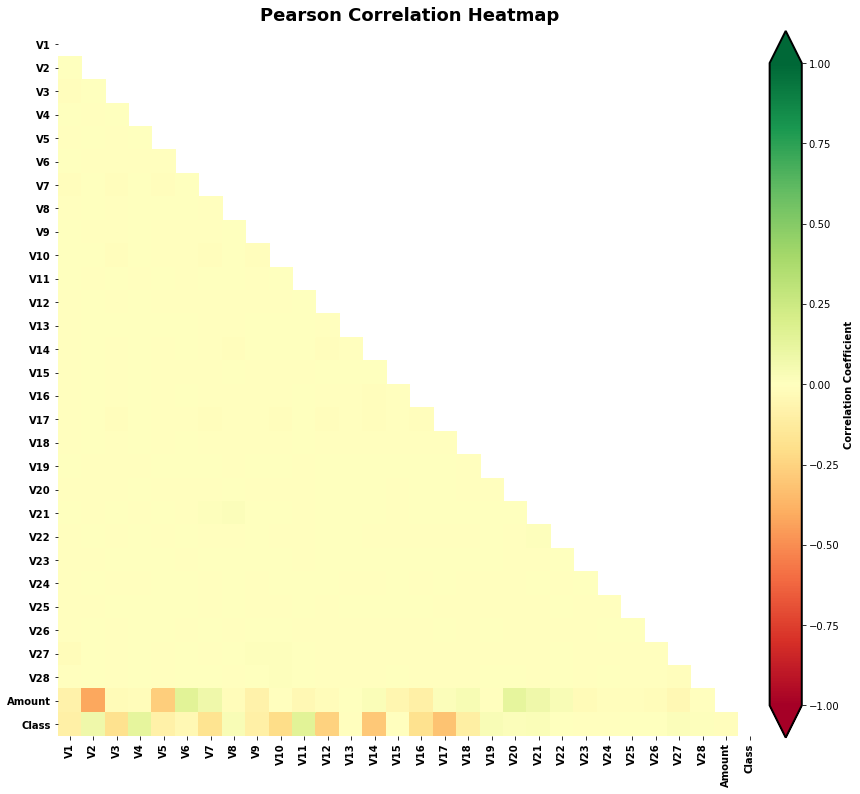

In [37]:
# Mapa de calor do coeficiente de correlação de Pearson para todas variáveis
mask = np.zeros_like(correlation_pearson)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 13))
ax = sns.heatmap(credit_card.corr(method='pearson'), mask=mask, vmin=-1, vmax=1, square = True, annot=False, cmap='RdYlGn',
                 cbar_kws={"extend": "both", "pad": 0.01})
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap_correlation_pearson.png', dpi=300, bbox_inches='tight')

ax.set_title('Pearson Correlation Heatmap', fontdict={'fontsize':18}, pad=12, weight="bold");
ax.set_xticklabels(ax.get_xticklabels(), weight="bold", rotation="vertical")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Correlation Coefficient", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
ax.collections[0].colorbar.outline.set_linewidth(2)

É difícil tirar alguma conclusão observado o mapa acima. Essa dificuldade decorre principalmente do grande desbalanço que há no nosso dataset. Todavia, podemos explorar alguns possíveis indícios presentes na coluna "Class". Aparentemente as colunas "V17", "V14" e "V12" possuem uma correlação negativa mais forte com o target e as colunas "V2", "V4" e "V11" uma correlação positiva mais forte se comparada as demais. Podemos explorar isso por meio de alguns boxplots dessas colunas. Vamos fazer isso. 

Primeiro vamos plotar os boxplots das variáveis que possuem correlação negativa com o alvo. A interpretação aqui é a seguinte: quanto menor for o seu valor maior a probabilidade de corresponder a uma transação fraudulenta.

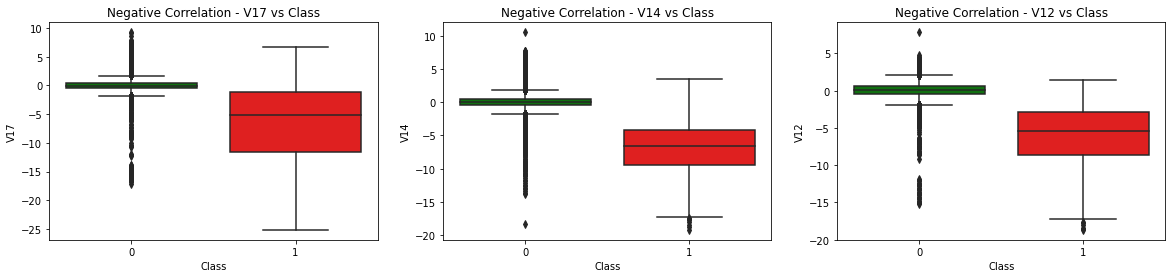

In [39]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))
colors=['green', 'red']

# Correlações Negativas separadas por classe
sns.boxplot(x="Class", y="V17", data=credit_card, palette=colors, ax=axes[0])
axes[0].set_title('Negative Correlation - V17 vs Class')

sns.boxplot(x="Class", y="V14", data=credit_card, palette=colors, ax=axes[1])
axes[1].set_title('Negative Correlation - V14 vs Class')

sns.boxplot(x="Class", y="V12", data=credit_card, palette=colors, ax=axes[2])
axes[2].set_title('Negative Correlation - V12 vs Class')

plt.show()

Essas três variáveis, de fato, possuem uma correlação negativa com o alvo. A mediana para a classe 1 possui um valor próximo a -5 nos três casos e, para a classe 0, é próxima de 0. Vemos também que o IQR nos três casos encontra-se situado completamente em valores negativos. 

Agora vamos repetir o mesmo procedimento mas com as variáveis positivamente correlacionadas. Nesse caso a interpretação que segue é: quanto maior for o seu valor maior a probabilidade de corresponder a uma transação fraudulenta.

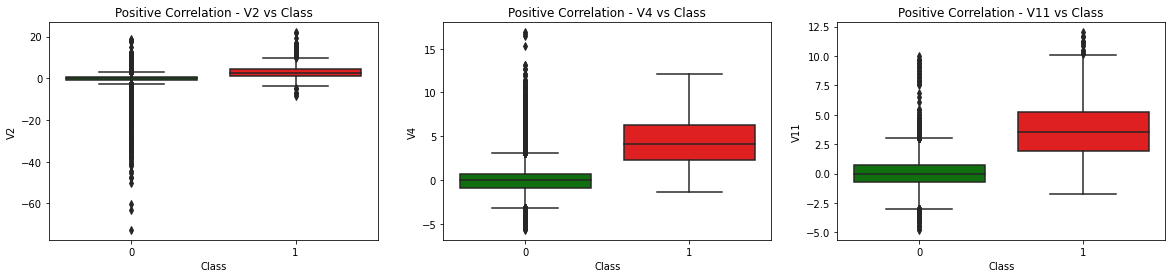

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))
colors=['green', 'red']

# Correlações Positivas separadas por classe
sns.boxplot(x="Class", y="V2", data=credit_card, palette=colors, ax=axes[0])
axes[0].set_title('Positive Correlation - V2 vs Class')

sns.boxplot(x="Class", y="V4", data=credit_card, palette=colors, ax=axes[1])
axes[1].set_title('Positive Correlation - V4 vs Class')

sns.boxplot(x="Class", y="V11", data=credit_card, palette=colors, ax=axes[2])
axes[2].set_title('Positive Correlation - V11 vs Class')

plt.show()

Novamente temos uma confirmação das nossas premissas. Talvez a variável "V2" seja demasiado exagerado inferir uma correlação positiva pra ela. Nas demais temos a mesma explicação do caso anterior, ou seja, os IQR's encontram-se ambos totalmente em valores positivos e a mediana das distribuições é maior do que a mediana associada a classe 0. 

#### 2.2.2 Correlação de Spearman

Vamos explorar a correlação de Spearman sobre as variáveis independentes do nosso dataset.

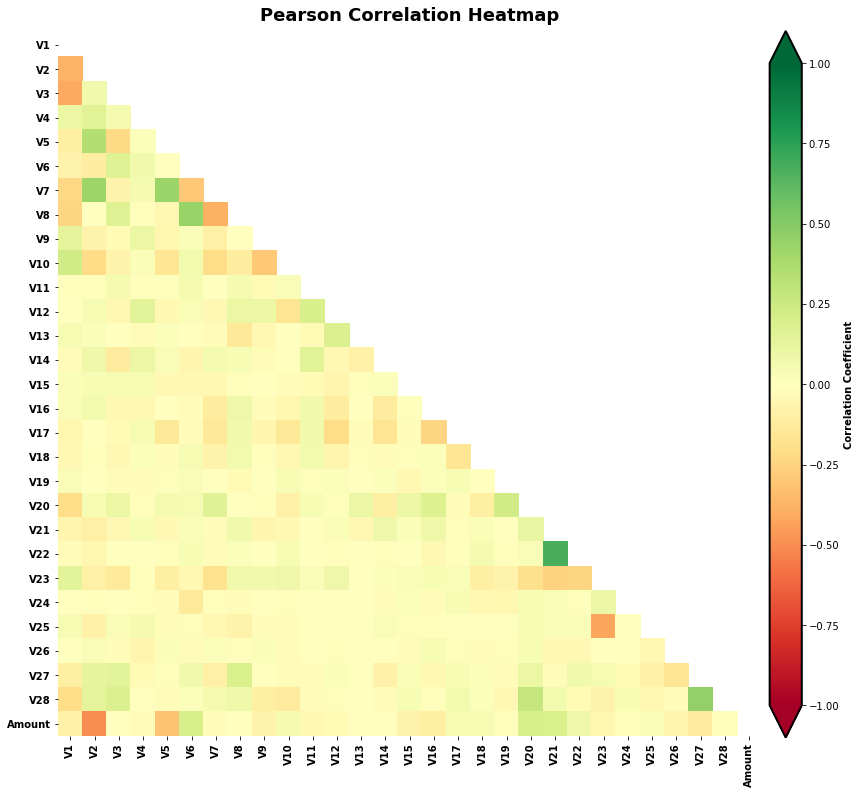

In [46]:
# Calculando a correlação de Spearman
correlation_spearman = variables.corr(method='pearson')

# Mapa de calor do coeficiente de correlação de Pearson para todas variáveis
mask = np.zeros_like(correlation_spearman)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 13))
ax = sns.heatmap(variables.corr(method='spearman'), mask=mask, vmin=-1, vmax=1, square = True, annot=False, cmap='RdYlGn',
                 cbar_kws={"extend": "both", "pad": 0.01})
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap_correlation_pearson.png', dpi=300, bbox_inches='tight')

ax.set_title('Pearson Correlation Heatmap', fontdict={'fontsize':18}, pad=12, weight="bold");
ax.set_xticklabels(ax.get_xticklabels(), weight="bold", rotation="vertical")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold", rotation='horizontal')
ax.collections[0].colorbar.set_label("Correlation Coefficient", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
ax.collections[0].colorbar.outline.set_linewidth(2)

Algumas observações que podemos fazer observando a matriz de correlação acima é a de que as variáveis "V22" e "V21" possuem uma forte correlação negativa, assim como "V27" com "V28", embora não tão forte como a primeira. Já para correlações positivas as que parecem mais fortes são "Amount" com "V2" e "V1" com "V3". 

No entanto, como essas variáveis foram todas anonimizadas e não sabemos que tipo de quantidade elas representam, fica difícil concluir algo mais elaborado acerca dessas correlações.

Por fim, vamos observar como se comporta a informação mútua entre as variáveis. 

#### 2.2.3 Informação Mútua

A informação mútua é uma quantidade interessante a ser observada no nosso caso. Ela quantifica a quantidade de informação (no sentido de informação de Shannon) que uma variável possui acerca da outra. Ou seja, se a informação mútua entre elas for alta, há uma grande intersecção entre a quantidade de informação (pode-se pensar na intersecção entre conjuntos matemáticos) de ambas, o que implica que conhecer uma variável te dá também bastante informação sobre a outra. Vamos calcular essa quantidade para os nossos dados.

In [48]:
# Calculando a informação mútua
mutual_info = mutual_info_classif(variables, target, random_state=42)

[1.85069622e-03 2.91950677e-03 4.58325270e-03 4.58678621e-03
 2.06543576e-03 1.99957026e-03 3.62995440e-03 1.60044322e-03
 3.85420994e-03 7.15022647e-03 6.44993589e-03 7.21967729e-03
 8.54745245e-05 7.74556991e-03 2.29293272e-05 5.75174888e-03
 7.87250642e-03 3.87526189e-03 1.12956098e-03 9.03738645e-04
 2.13854324e-03 1.25943500e-04 4.70511658e-04 3.64324525e-04
 2.52600329e-04 2.39426095e-04 2.16640304e-03 1.60654683e-03
 1.43646937e-03]


In [50]:
# Ordenando da maior informação mútua para a menor - formando uma Series separada pelo valor de cada coluna
mutual_info_Series=pd.Series(mutual_info, index=variables.columns)
mutual_info_Series.sort_values(ascending=False, inplace=True)

Text(0.5, 0, 'Features')

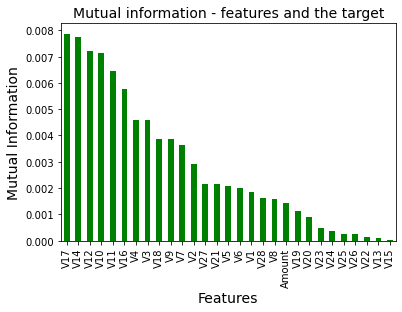

In [55]:
# Plotando um histograma com os resultados
mutual_info_Series.plot.bar(color = 'green')
plt.title("Mutual information - features and the target", fontsize = 14)
plt.ylabel("Mutual Information", fontsize = 14)
plt.xlabel("Features", fontsize = 14)

É interessante ver por meio desse histograma que as 3 variáveis que possuem maior informação mútua são exatamente as 3 variáveis que possuem maior correlação negativa com o alvo. Talvez isso fosse esperado, uma vez que se há uma forte correlação entre elas (ou seja, se a intensidade da relação linear entre elas é alta nesse caso), conhecer uma variável ajuda a conhecer a outra e, portanto, há um ganho de informação acerca entre ambas.

## 3) Criando um Modelo de Base 

Após realizada a análise dos dados, agora temos um conhecimento melhor acerca de que tipo de problema estamos lidando. Como nosso objetivo final será utilizar modelos de Machine Learning para prever a classe das transações, faz-se interessante, primeiramente, criar um modelo de base por meio da técnica de DummyClassifier. O que isso significa? A ideia consiste em criar um modelo de classificação muito simples, que funciona como espécie de "chute randômico" acerca das classes que queremos conhecer. Em suma, esperamos que qualquer modelo que iremos utilizar depois tenha uma performance melhor do que o DummyClassifier. Primeiro vamos discutir quais métricas usaremos para avaliar a performance dos modelos e, na sequência, construiremos o modelo de base.

### 3.1 Estabelecendo as métricas de avaliação de performance

O primeiro passo será estabelecer que tipo de métrica iremos utilizar como avaliador da performance dos nossos modelos. Essa decisão depende principalmente do tipo de produto e objeto que estamos querendo compreender. Vamos pensar sobre o nosso caso. Temos um conjunto de dados completamente desbalanceado, no sentido que existe um número muito maior de transações genuínas em comparação as transações fraudulentas. O objetivo final é diminuir ao máximo o número de transações classificadas como genuínas mas que na verdade são fraudulentas, i.e., queremos diminuir o número de **falsos positivos** - esses são os casos que trarão maior prejuízo financeiro a empresa. O caso de **falsos negativos**, i.e., transações genuínas que são classificadas como fraudulentas, embora também sejam problemáticos, trazem um prejuízo financeiro menor.   

#### 3.1.1 A métrica $F\beta-\rm{score}$ e $F2-\rm{score}$

Uma vez entendido qual quantidade queremos otimizar, a pergunta que se coloca é: qual métrica usaremos pra avaliar o nosso modelo? Vamos observar as expressões para duas métricas avaliadores de classe, a saber, **Recall** e **Precision**:

$$\rm{\textbf{Precision}}=\frac{\textrm{True Positives}}{\textrm{True Positives + False Positives}},$$

$$\rm{\textbf{Recall}}=\frac{\textrm{True Positives}}{True Positives + False Negatives}.$$

Como queremos diminuir o número de falsos negativos, logo queremos maximizar Recall. Portanto devemos focar mais nela. No entanto, o aumento de Recall causa uma diminuição na Precision, o que também não é bom. Em suma, embora desejamos uma melhor performance na Recall, há de se ter um balanço entre as duas para que também haja uma boa maximização da Precision. Para realizar tal tarefa, usaremos a métrica $F\beta-\rm{score}$, que é uma generalização da $F1-\rm{score}$ (média harmônica entre Recall e Precision), onde podemos dar um peso maior ao Recall, como desejamos. A expressão dela é dada por:

$$F\beta-\rm{score}=\frac{(1+\beta^{2})\times\rm{Precision}\times\rm{Recall}}{(\beta^{2}\times\rm{Precision}+\rm{Recall})},$$

onde $\beta$ é o peso que queremos dar a Recall. No nosso caso iremos escolher $\beta=2$ e usaremos a $F2-\rm{score}$ como métrica.

#### 3.1.2 A área sob a curva Precision-Recall

A área sob a curva Precision-Recall é uma quantidade bastante eficiente para medirmos a eficácia dos modelos em caso bastante desbalanceados como o nosso - é, inclusive, a sugestão dada na descrição do problema no Kaggle. Para entendermos melhor, a curva Precision-Recall nada mais é do que um plot da Precision, representada no eixo-y, pelo Recall, representado no eixo-x. A curva é obtida variando o threshold do problema. O threshold funciona como um valor limiar a partir do qual classificamos a probabilidade calculada nos dados ser uma fraude ou uma transação genuína. 

Assim, quanto mais próximo de 1 a área sob a curva, melhor o modelo, uma vez que ele está obtendo um excelente valor tanto para a Precision (diminuindo o número de falsos positivos) quanto para o Recall (diminuindo o número de falsos negativos).

### 3.2 O modelo de base - DummyClassifier

Vamos criar o nosso base model simples usando o DummyClassifier. Primeiro precisamos separar nossos dados em subconjuntos de treino e teste. Iremos fixar 70% dos dados para treino e 30% para teste.

In [56]:
# Denotando as variáveis por X
X = variables

# Denotando o target por y
y = target

# Realizando a separação entre dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [57]:
# Checkando se o shape dos dados de treino e teste são iguais - é necessário para o fit funcionar
print(f'Shape do X_train : {X_train.shape}')
print(f'Shape do y_train : {y_train.shape}')
print(f'Shape do X_test : {X_test.shape}')
print(f'Shape do y_test : {y_test.shape}')

Shape do X_train : (198608, 29)
Shape do y_train : (198608,)
Shape do X_test : (85118, 29)
Shape do y_test : (85118,)


Agora vamos construir o nosso modelo de base que seja o mais simples possível. Para isso usaremos o DummyClassifier. Usaremos um modelo que prevê a classe minoritária para todos os casos. 

In [58]:
# Definindo o modelo de referência
model_dummy = DummyClassifier(strategy = 'constant', constant = 1)

# Treinando o modelo nos dados de treino
model_dummy.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='constant')

In [59]:
# Previsão do modelo
y_pred = model_dummy.predict(X_test)

# Calcula as previsões como probabilidades
y_pred_proba = model_dummy.predict_proba(X_test)[:, 1] 

In [60]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred, y_pred_proba, model_dummy)

Avaliando o modelo de base para a métrica F2 : 0.01
Avaliando o modelo de base para a métrica Precision : 0.00
Avaliando o modelo de base para a métrica Recall : 1.00
Avaliando o modelo de base para a métrica AUC-PR : 0.00


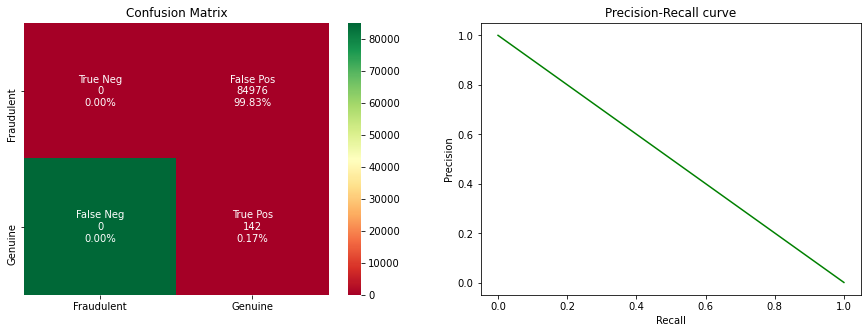

<Figure size 432x288 with 0 Axes>

In [65]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred, y_pred_proba, model_dummy)

Obviamente um modelo artificial que prevê a classe 1 para todos os casos possui um Recall de 100%, uma vez que não haverão falsos negativos - ele acerta todos. Todavia, o Precision é praticamente 0, o que é péssimo. Quanto a área sob a curva Precision-Recall, não daremos muita atenção nesse caso. Esse é um caso muito patológico. Temos um voto fixo de 1 para todos os casos e acredito que ele está somente interpolando os únicos dois pontos que existem (0 e 1), independente do threshold. 

Como dissemos anteriormente, esse modelo somente servirá como base para os outros modelos que construiremos, no sentido de que os próximos resultados obtidos devem ser superiores a esse. 

Na sequência iremos analisar o problema do desbalanceamento dos nossos dados e como podemos resolvê-lo.

## 4) Normalizando as variáveis

Alguns modelos lineares como regressão logística e regressão linear pressupõem que os dados seguem uma distribuição aproximadamente gaussiana. Como vimos anteriormente, nossos dados não seguem uma distribuição gaussiana. Desse modo, como proceder? O que iremos fazer é realizar uma transformação de Yeo-Johnson nos nossos dados de tal forma a deixá-los o mais próximo possível de uma distribuição gaussiana. Isso nos permitirá utilizar o modelo de regressão logística para prever as classes.  

In [66]:
# Instanciando a transformação
pt = PowerTransformer(method = 'yeo-johnson', standardize = True)

# Realizando um fit da transformação nos dados de treino
X_train = pt.fit_transform(X_train)

# Aplicando a transformação 
X_test = pt.transform(X_test)

## 5) Analisando o desbalanceamento dos dados

Como analisamos no começo do notebook, os nossos dados são altamente desbalanceados dado que a classe 0, correspondendo a transações genuínas, compõem ~99,8% dos valores no target, enquanto que a classe 1, correspondendo as transações fraudulentas, compõem ~0,17% dos valores. Como lidar com esse problema?

Existem inúmeros métodos para lidar com dados desbalanceados. No nosso caso exploraremos somente três deles. O primeiro corresponde a um **oversampling** da classe minoritária, i.e, tomamos a classe minoritária (1 no nosso caso) e duplicamos diversos dados ali contidos, de tal modo que o balanço final seja mais equilibrado com a classe majoritária. Na sequência iremos realizar um **undersampling**, que consiste em eliminar diversos dados da classe majoritária de tal modo que ambas fiquem equilibradas ao final. Por fim, iremos utilizar um método conhecido como **SMOTE**, que consiste em criar dados sintéticos da classe minoritária baseado nos vizinhos mais próximos, resultando em um equilíbrio entre as duas classes ao final do processo.  

Iremos testar as técnicas por meio de uma regressão logística e ver o que irá performar melhor. 

### 5.1 Oversampling na classe minoritária

Vamos primeiro fazer um plot de espalhamento de duas features dos dados de treino para vermos o desbalanço entre as classes. 

In [67]:
# Transformando os dados de treino, X_train e y_train, em arrays
X_train_array = np.array(X_train).astype(np.float64)
y_train_array = np.array(y_train).astype(np.float64)

Counter({0.0: 198277, 1.0: 331})


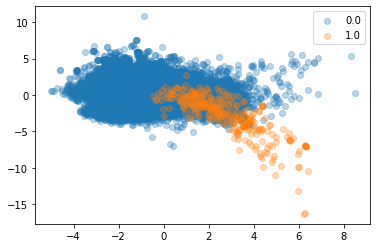

In [79]:
# Conta quantos elementos cada classe possui
counter = Counter(y_train_array)
print(counter)

# Gráfico de espalhamento de duas colunas dos dados de treino separados por classe
for label, _ in counter.items():
    row_ix = where(y_train_array == label)[0]
    plt.scatter(X_train_array[row_ix, 3], X_train_array[row_ix, 8], label=str(label), alpha=0.3)
plt.legend()
plt.show()

Agora vamos realizar o oversampling na classe minoritária e depois plotar o mesmo tipo de gráfico de espalhamento para vermos a mudança

In [69]:
# Instanciando o RandomOverSampler - vamos manter um desbalanço de 3/4 entre as classes
ros = RandomOverSampler(sampling_strategy=3/4, random_state=42)

# Fazendo o oversampling nos dados de treino
X_over_resampled, y_over_resampled = ros.fit_resample(X_train, y_train)

In [70]:
# Transformando os dados resampled em arrays
X_over_resampled_array = np.array(X_over_resampled).astype(np.float64)
y_over_resampled_array = np.array(y_over_resampled).astype(np.float64)

Counter({0.0: 198277, 1.0: 148707})


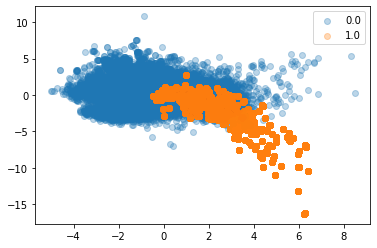

In [71]:
# Conta quantos elementos cada classe possui
counter = Counter(y_over_resampled_array)
print(counter)

# Gráfico de espalhamento de duas colunas dos dados de treino separados por classe
for label, _ in counter.items():
    row_ix = where(y_over_resampled_array == label)[0]
    plt.scatter(X_over_resampled_array[row_ix, 3], X_over_resampled_array[row_ix, 8], label=str(label), alpha=0.3)
plt.legend()
plt.show()

Comparando as duas figuras fica nítido que os dados são replicados na classe minoritária até a proporção ser a de 3/4 - veja os tons de laranja mais escuros na figura acima comparado com a primeira. Esse também é o ponto fraco do método, i.e., o modelo irá aprender em dados duplicados. 

Vamos realizar uma regressão logística nos dados de treino oversampled. 

In [72]:
# Instanciando a regressão logística
model_lr = LogisticRegression()

# Treinando o modelo nos dados de treino resampled
model_lr.fit(X_over_resampled, y_over_resampled)

# Realizando a previsão
y_pred = model_lr.predict(X_test)

# Prevendo probabilidades 
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

E agora vamos avaliar essa regressão logística com a classe minoritária oversampled

In [73]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred, y_pred_proba, model_lr)

Avaliando o modelo de base para a métrica F2 : 0.25
Avaliando o modelo de base para a métrica Precision : 0.07
Avaliando o modelo de base para a métrica Recall : 0.89
Avaliando o modelo de base para a métrica AUC-PR : 0.69


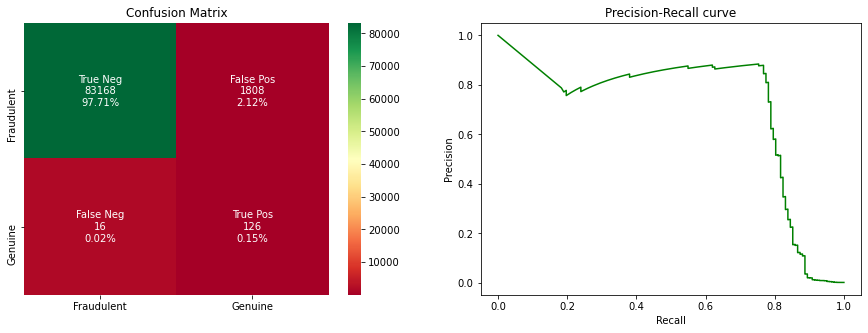

<Figure size 432x288 with 0 Axes>

In [74]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred, y_pred_proba, model_lr)

Somente uma técnica simples de Oversampling já fornece uma área sob a curva Precision-Recall de 0.69 e um Recall de 0.89. No entanto, esse modelo ainda está muito básico - estamos usando só para ver qual tipo de técnica para lidar com o desbalanceamento funciona melhor. 

### 5.2 Undersampling na classe majoritária

Vamos repetir os passos do procedimento anterior mas agora realizando um Undersampling na classe majoritária, i.e., estamos descartando dados da classe 0 de tal forma a obtermos um equilíbrio ao final. 

In [80]:
# Instanciando o RandomUnderSampler - mantendo um desbalanço de 3/4 entre as classes
rus = RandomUnderSampler(sampling_strategy=3/4, random_state=42)

# Fazendo o oversampling nos dados de treino
X_under_resampled, y_under_resampled = rus.fit_resample(X_train, y_train)

In [81]:
# Transformando os dados resampled em arrays
X_under_resampled_array = np.array(X_under_resampled).astype(np.float64)
y_under_resampled_array = np.array(y_under_resampled).astype(np.float64)

Counter({0.0: 441, 1.0: 331})


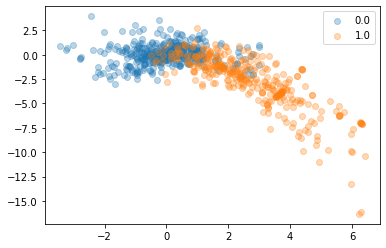

In [82]:
# Conta quantos elementos cada classe possui
counter = Counter(y_under_resampled_array)
print(counter)

# Gráfico de espalhamento de duas colunas dos dados de treino separados por classe
for label, _ in counter.items():
    row_ix = where(y_under_resampled_array == label)[0]
    plt.scatter(X_under_resampled_array[row_ix, 3], X_under_resampled_array[row_ix, 8], label=str(label), alpha=0.3)
plt.legend()
plt.show()

Por meio da imagem acima fica claro que os dados da classe 1 são mantidos iguais ao inicial e a classe majoritária é diminuída até que tenhamos uma proporção de 3/4 entre elas.

Vamos agora treinar o modelo e ver como ele performa. 

In [83]:
# Treinando o modelo nos dados de treino resampled
model_lr.fit(X_under_resampled, y_under_resampled)

# Realizando a previsão
y_pred_under = model_lr.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_under = model_lr.predict_proba(X_test)[:, 1]

In [84]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_under, y_pred_proba_under, model_lr)

Avaliando o modelo de base para a métrica F2 : 0.17
Avaliando o modelo de base para a métrica Precision : 0.04
Avaliando o modelo de base para a métrica Recall : 0.89
Avaliando o modelo de base para a métrica AUC-PR : 0.46


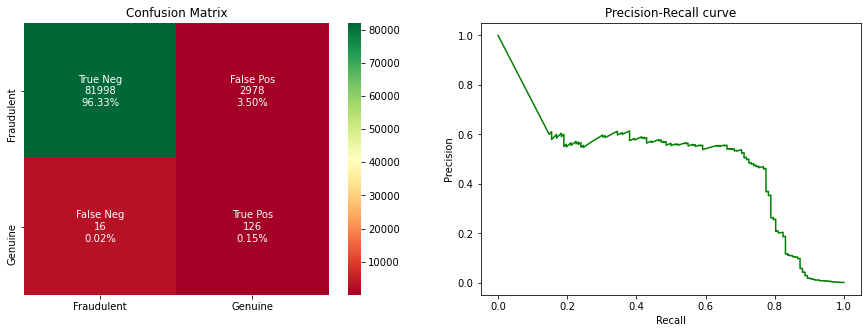

<Figure size 432x288 with 0 Axes>

In [85]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_under, y_pred_proba_under, model_lr)

Nesse caso temos uma área sob a curva Precision-Recall inferior ao caso anterior, embora o Recall ainda seja o mesmo. A métrica F2 também é inferior. Isso quer dizer que o Undersampling é uma técnica inferior? Não necessariamente. Cada caso precisa ser analisado de modo individual. Talvez aqui o desbalanço entre as classes seja tão grande que ao tentarmos balanceá-las estaremos jogando um número muito grande de dados fora e o modelo acaba performando pior. 

Ao mesmo tempo o caso anterior de Oversampling pode ser enviesado, no sentido que o modelo aprende por meio de dados duplicados somente. Isso pode trazer um viés aos resultados. 

Vamos aplicar uma técnica um pouco mais elaborada na sequência, conhecida como SMOTE (Synthetic Minority Oversampling Technique).

### 5.3 Aplicação da técnica SMOTE

A técnica SMOTE consiste num balanceamento das classes por meio de um oversampling sintético na classe minoritária. Diferente do oversampling anterior onde os dados da classe minoritária eram duplicados somente, aqui ocorre um procedimento um pouco mais elaborado. A técnica seleciona randomicamente um elemento da classe minoritária e, a partir dele, escolhe mais um número $k$ de vizinhos próximos. A partir daí realiza-se uma interpolação linear entre o elemento primeiramente selecionado e um dos seus vizinhos. Após isso cria-se um dado sintético num ponto escolhido entre esses dois. Com isso têm-se a criação de inúmeros novos pontos que não são simplesmente cópias do que haviam anteriormente. 

Vamos executar esse procedimento nos nossos dados.

In [86]:
# Instanciando o SMOTE - vamos estabelecer uma proporção de 15% da classe 1 em relação a classe 0
smote = SMOTE(sampling_strategy=0.15, random_state=42)

# Fazendo o oversampling nos dados de treino
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_train, y_train)

In [87]:
# Transformando os dados resampled em arrays
X_smote_resampled_array = np.array(X_smote_resampled).astype(np.float64)
y_smote_resampled_array = np.array(y_smote_resampled).astype(np.float64)

Counter({0.0: 198277, 1.0: 29741})


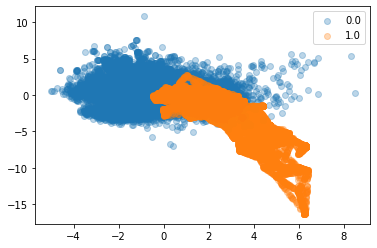

In [88]:
# Conta quantos elementos cada classe possui
counter = Counter(y_smote_resampled_array)
print(counter)

# Gráfico de espalhamento de duas colunas dos dados de treino separados por classe
for label, _ in counter.items():
    row_ix = where(y_smote_resampled_array == label)[0]
    plt.scatter(X_smote_resampled_array[row_ix, 3], X_smote_resampled_array[row_ix, 8], label=str(label), alpha=0.3)
plt.legend()
plt.show()

In [89]:
# Treinando o modelo nos dados de treino resampled
model_lr.fit(X_smote_resampled, y_smote_resampled)

# Realizando a previsão
y_pred_smote = model_lr.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_smote = model_lr.predict_proba(X_test)[:, 1]

In [90]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_smote, y_pred_proba_smote, model_lr)

Avaliando o modelo de base para a métrica F2 : 0.59
Avaliando o modelo de base para a métrica Precision : 0.27
Avaliando o modelo de base para a métrica Recall : 0.83
Avaliando o modelo de base para a métrica AUC-PR : 0.72


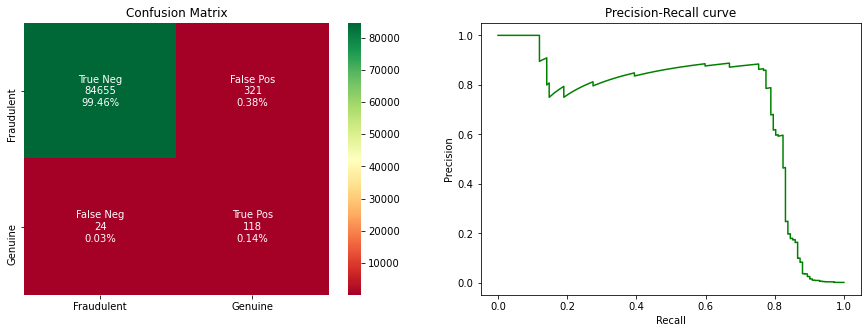

<Figure size 432x288 with 0 Axes>

In [91]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_smote, y_pred_proba_smote, model_lr)

Nesse caso temos uma área sob a curva de 0.72, um Recall de 0.83, Precision de 0.27 e F2 de 0.58. Como podemos ver, esse método para lidar com o desbalanceamento aparentemente funciona melhor que os outros dois - embora o Recall seja um pouco menor a Precision é bem superior, assim como a área sob a curva Precision-Recall.

Vamos tentar uma combinação de duas técnicas na sequência. Primeiro realizaremos um SMOTE na clásse minoritária, como acabamos de fazer e, na sequência, realizaremos um Undersampling na classe majoritária. 

#### 5.4 Combinando SMOTE com Undersampling

In [92]:
# Instanciando o classificador de regressão logística 
model_lr = LogisticRegression()

# Instanciando os métodos de balanceamento
rus = RandomUnderSampler(sampling_strategy = 0.75, random_state=42)

smote = SMOTE(sampling_strategy = 0.15, random_state = 42)

In [93]:
# Criando uma pipeline para a aplicação dos processos em sequência
pipeline = Pipeline([('smote', smote), ('rus', rus), ('model_lr', model_lr)])

# Treinando os dados com essa pipeline
pipeline.fit(X_train, y_train)

# Realizando a previsão
y_pred_smu = pipeline.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_smu = pipeline.predict_proba(X_test)[:, 1]

In [94]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_smu, y_pred_proba_smu, model_lr)

Avaliando o modelo de base para a métrica F2 : 0.24
Avaliando o modelo de base para a métrica Precision : 0.06
Avaliando o modelo de base para a métrica Recall : 0.89
Avaliando o modelo de base para a métrica AUC-PR : 0.68


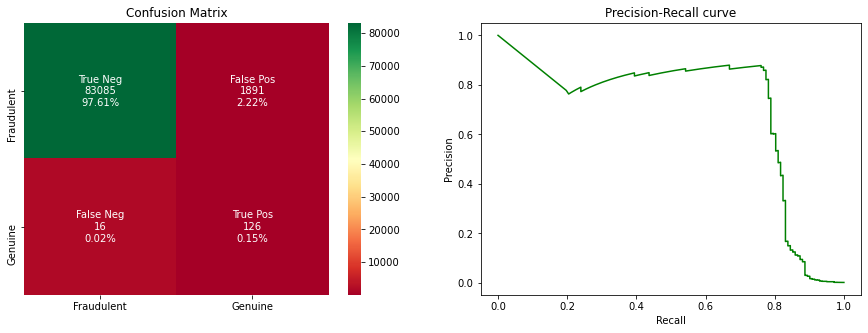

<Figure size 432x288 with 0 Axes>

In [95]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_smu, y_pred_proba_smu, model_lr)

Esse caso combina duas técnicas em sequência e temos como resultado um F2 de 0.25, um Recall de 0.89 mas uma Precision de somente 0.06. A área sob a curva Precision-Recall também é inferior ao caso SMOTE sozinho. 

Vamos fazer a opção por manter somente a técnica SMOTE nos modelos que construiremos na sequência. 

## 6) Aplicandos os modelos de Machine Learning

Nesse capítulo iremos utilizar alguns modelos de classificação para tentar prever as classes do problema. Fixaremos o método SMOTE para balancear os dados e utilizaremos três modelos na nossa proposta: 1) Regressão Logística, 2) Random Forest e 3) XGBoost. A ideia será realizar um tuning dos hiperparâmetros em todos eles de tal modo a alcançarmos uma performance melhor. Também vamos explorar quais features foram mais importantes em cada modelo com o intuito de explorar se existe uma intersecção entre elas para todos os casos e se é compatível com o que discutimos na análise exploratória.

### 6.1 Regressão Logística

Embora já tenhamos realizado a regressão logística combinada com algumas técnicas para lidar com o desbalanço, a proposta agora é aperfeiçoar os resultados desse método através de um tunning nos hiperparâmetros do modelo. Inicialmente vamos reescrever os resultados da Regressão Logística combinada com a técnica SMOTE, sendo esse o "modelo base" de regressão - só para facilitar a comparação.

#### 6.1.1 Modelo de base 

In [158]:
# Instanciamos o classificador de regressão logística  
model_lr = LogisticRegression()

# Instanciamos o SMOTE
smote = SMOTE(sampling_strategy = 0.15, random_state = 42)

# Vamos criar uma pipeline
pipeline = Pipeline([('smote', smote), ('model_lr', model_lr)])

# Treinando a pipeline nos dados
pipeline.fit(X_train, y_train)

# Realizando a previsão 
y_pred_lr = pipeline.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_lr = pipeline.predict_proba(X_test)[:, 1]

In [159]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, model_lr)

Avaliando o modelo de base para a métrica F2 : 0.59
Avaliando o modelo de base para a métrica Precision : 0.27
Avaliando o modelo de base para a métrica Recall : 0.83
Avaliando o modelo de base para a métrica AUC-PR : 0.72


Esse foi o resultado que obtivemos no capítulo anterior. Ele servirá de base. Agora vamos tentar melhorar a performance do modelo utilizando uma técnica de tuning nos hiperparâmetros da regressão logística utilizando o GridSearchCV. Vamos definir o grid de parâmetros, realizar a validação cruzada usando esse grid, treinar o modelo e, ao fim, obter a melhor combinação possível desses hiperparâmetros usando Recall como scoring.

#### 6.1.2 Modelo com tuning nos hiperparâmetros

Os parâmetros que iremos escolher consiste do parâmetro C, que controla o inverso da intensidade da regularização e o solver do modelo. A regularização serve para evitar que ocorra overfitting no modelo, uma vez que esse parâmetro "pune" o aprendizado em dados mais complexos. Então quanto maior for a regularização, menor é o parâmetro C e e vice-versa. Já o solver é o algoritmo escolhido na otimização.

In [98]:
# Definindo o grid de parâmetros
param_grid = {'model_lr__C': [0.01, 0.1, 1.0, 10, 100], 'model_lr__solver': ['newton-cg', 'lbfgs', 'liblinear']}

In [99]:
# Realizando uma cross-validation usando RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

# Combinando o grid de parâmetros com a pipeline contendo o modelo
CV_model_lr = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv=cv, scoring = 'recall', n_jobs = -1)

In [100]:
# Treinando o modelo nos dados
CV_model_lr.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.15)),
                                       ('model_lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model_lr__C': [0.01, 0.1, 1.0, 10, 100],
                         'model_lr__solver': ['newton-cg', 'lbfgs',
                                              'liblinear']},
             scoring='recall')

In [101]:
# Obtendo a melhor combinação de hiperparâmetros
CV_model_lr.best_params_

{'model_lr__C': 0.1, 'model_lr__solver': 'newton-cg'}

In [102]:
# Obtendo o melhor score
CV_model_lr.best_score_

0.863169003467511

Será que utilizar esses hiperparâmetros no nosso classificador irá melhorar os resultados dos scores? Vamos testar.

In [153]:
# Testando esses parâmetros
model_lr_tun = LogisticRegression(C=0.1, solver = 'newton-cg')
pipeline = Pipeline([('smote', smote), ('model_lr', model_lr)])

# Treinando a pipeline nos dados
pipeline.fit(X_train, y_train)

# Realizando a previsão 
y_pred_lr_tun = pipeline.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_lr_tun = pipeline.predict_proba(X_test)[:, 1]

In [154]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_lr_tun, y_pred_proba_lr_tun, model_lr)

Avaliando o modelo de base para a métrica F2 : 0.59
Avaliando o modelo de base para a métrica Precision : 0.27
Avaliando o modelo de base para a métrica Recall : 0.83
Avaliando o modelo de base para a métrica AUC-PR : 0.72


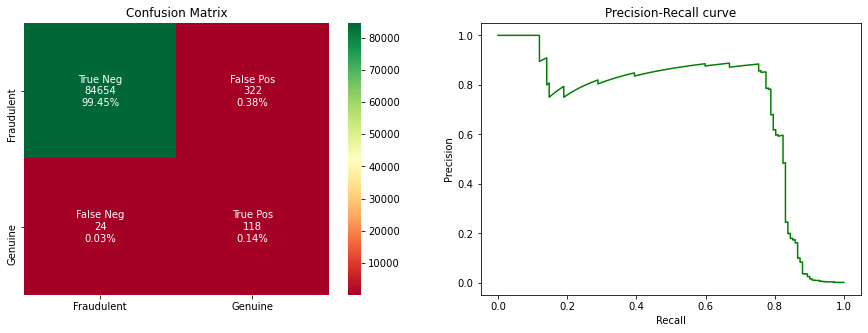

<Figure size 432x288 with 0 Axes>

In [155]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_lr_tun, y_pred_proba_lr_tun, model_lr_tun)

Como vemos, mesmo após tunarmos os hiperparâmetros da regressão logística, o resultado se manteve o mesmo. Talvez isso tenha ocorrido pela regressão logística não possuir muitos hiperparâmetros a serem ajustados ou talvez porque os dados do nosso alvo sejam tão desbalanceados que, utilizando esse método, realmente é difícil obter uma melhora nos resultados.

Nossa próxima tarefa nessa seção de regressão logística será buscar quais foram as features mais importantes utilizadas pelo modelo ao realizar as previsões.

#### 6.1.3  A importância das features

Para esse caso de Regressão Logística, iremos obter a importância das features por meio da importância dos coeficientes da regressão. Basicamente o valor do coeficiente diz que se a variável associada foi acrescida de uma unidade, a variável dependente, i.e., o alvo, irá aumentar (ou diminuir) pelo coeficiente associado - caso todas outras variáveis se mantenham fixadas. 

Esse não é o método mais robusto para se determinar a importância das features mas consegue nos fornecer uma ideia geral do que está ocorrendo. 

Vamos então descrever um barplot com os coeficientes da Regressão Logística.



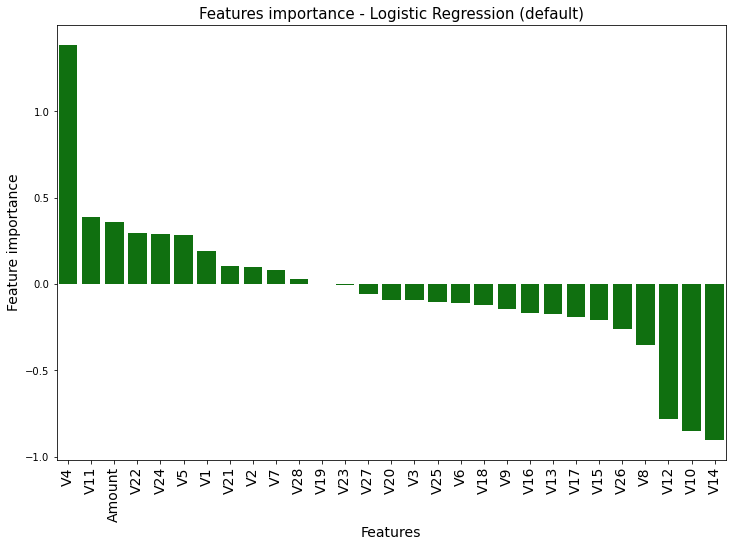

In [186]:
plt.figure(figsize = (12,8))
# Lista de variáveis
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
            'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Construindo um data frame, ordenando por importância da variável, da maior para a menor
features_import = pd.DataFrame({'Feature': features, 'Feature importance': model_lr.coef_[0]})
features_import = features_import.sort_values(by='Feature importance', ascending=False)

# Plotando um barplot
g = sns.barplot(x='Feature', y='Feature importance', data=features_import, color='g')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=14)
g.set_ylabel('Feature importance', fontsize=14)
g.set_xlabel('Features', fontsize=14)
g.set_title('Features importance - Logistic Regression (default)',fontsize=15)
plt.show() 

Por esse plot notamos que os coeficiente que possuem mais "peso" no comportamento do target são aqueles associados as variáveis "V4" e "V14". No caso da "V4" o coeficiente é positivo, o que nos diz que ele tem um "impacto" maior em fazer o target assumir o valor 1 e, no caso da "V14", ele tem um impacto maior em fazer o target assumir o valor 0.

É interessante notar que há uma intersecção entre esse resultado e a análise que fizemos no início quando exploramos nossos dados. Lá havíamos obtido que as variáveis "V14" e "V12" possuíam uma correlação negativa com o alvo e as variáveis "V4" e "V11" uma correlação positiva. O plot acima concorda com aquela análise.

Vamos agora para o segundo modelo a ser analisado, a Random Forest.

### 6.2 Random Forests

Random Forest é um modelo bastante eficaz tanto para problemas de regressão quanto de classificação. O fato dele se basear num ensemble de árvores de decisão faz com que as chances de ocorrer um overfitting (muito comum nas árvores de decisão individuais) diminuam muito. Além disso, as premissas de normalidade que utilizamos na Regressão Logística já não são mais necessárias aqui, uma vez que numa árvore de decisão no fundo o que está ocorrendo é uma sequência de questionamentos ("if"/"else") de tal forma a splitar o modelo até atingir um estágio final onde o modelo decide em quais classes se encontram os dados analisados. 

Como fizemos no caso anterior, vamos primeiro treinar um modelo de base sem nenhum tuning nos hiperaparâmetros e, na sequência, faremos esse tuning para ver se os resultados melhoram ou não. Por fim, também analisaremos quais features foram mais importantes para o modelo. 

#### 6.2.1 Modelo de Base

In [107]:
# Instanciamos o classificador da Random Forest
model_rf = RandomForestClassifier(random_state=5)

# Pipeline para a Random Forest
pipeline_rf = Pipeline([('smote', smote), ('model_rf', model_rf)])

# Treinando a pipeline nos dados
pipeline_rf.fit(X_train, y_train)

# Realizando a previsão 
y_pred_rf = pipeline_rf.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

In [108]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, model_rf)

Avaliando o modelo de base para a métrica F2 : 0.78
Avaliando o modelo de base para a métrica Precision : 0.93
Avaliando o modelo de base para a métrica Recall : 0.75
Avaliando o modelo de base para a métrica AUC-PR : 0.83


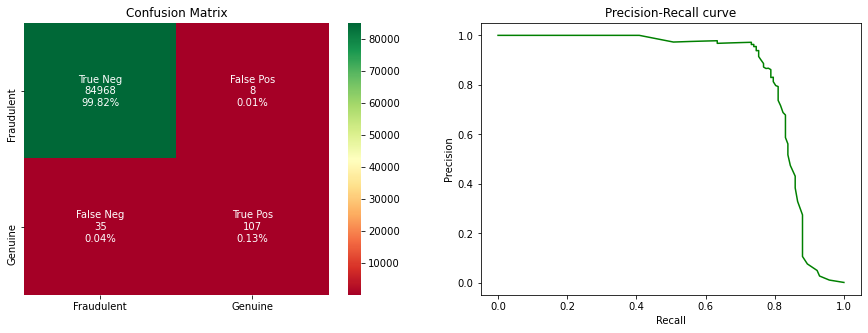

<Figure size 432x288 with 0 Axes>

In [109]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_rf, y_pred_proba_rf, model_rf)

O modelo de Random Forest com todos parâmetros default atingiu uma Precision de 0.93, um Recall de 0.75 e área sob a curva Precision-Recall foi de 0.83. Embora esse modelo não tenha atingido o melhor valor de Recall, ele foi o que obteve a melhor área sob a curva Precision-Recall. Talvez o ideal seria tentar encontrar alguma combinação de hiperparâmetros que tentasse pelo menos manter esse valor da área e aumentasse a Recall, diminuindo um pouco a Precision, que está com um valor excelente para um modelo default - todavia, vale lembrar que para nós a Recall é mais importante que a Precision.

Vamos tentar uma combinação de hiperparâmetros para ver se o modelo melhora. 

#### 6.2.2 Modelo com tuning nos hiperparâmetros

Os hiperparâmetros que estamos tunando nessa Random Forest são: 1) max_depth: esse valor descreve a profundidade máxima das árvores - árvores muito profundas tendem a "overfitar"; 2) min_samples_leaf: esse valor descreve o número mínimo de amostras que devem estar presentes em uma "folha" - ou seja, não haverão mais splits após atingir essa "folha"; 3) min_samples_leaf: nesse caso é o número de amostras mínimo para que um split seja realizado.   

In [142]:
# Definindo o grid de parâmetros
param_grid = {
    'model_rf__max_depth': [5, 8, 10],
    'model_rf__min_samples_leaf': [5, 8],
    'model_rf__min_samples_split': [4, 6]
}

CV_model_rf = RandomizedSearchCV(estimator=pipeline_rf, param_distributions=param_grid, cv=3, scoring='recall',
                                 n_jobs=-1)

In [143]:
# Treinando o modelo nos dados
CV_model_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(random_state=42,
                                                    sampling_strategy=0.15)),
                                             ('model_rf',
                                              RandomForestClassifier(random_state=5))]),
                   n_jobs=-1,
                   param_distributions={'model_rf__max_depth': [5, 8, 10],
                                        'model_rf__min_samples_leaf': [5, 8],
                                        'model_rf__min_samples_split': [4, 6]},
                   scoring='recall')

In [144]:
# Obtendo a melhor combinação de hiperparâmetros
CV_model_rf.best_params_

{'model_rf__min_samples_split': 4,
 'model_rf__min_samples_leaf': 8,
 'model_rf__max_depth': 5}

Agora vamos testar o modelo com esses parâmetros novos e ver qual será sua performance.

In [145]:
# Instanciamos o classificador da Random Forest
model_rf_tun = RandomForestClassifier(max_depth = 5, min_samples_leaf = 8, min_samples_split = 4, random_state=5)

# Pipeline para a Random Forest
pipeline_rf_tun = Pipeline([('smote', smote), ('model_rf', model_rf_tun)])

# Treinando a pipeline nos dados
pipeline_rf_tun.fit(X_train, y_train)

# Realizando a previsão 
y_pred_rf_tun = pipeline_rf_tun.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_rf_tun = pipeline_rf_tun.predict_proba(X_test)[:, 1]

In [146]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_rf_tun, y_pred_proba_rf_tun, model_rf_tun)

Avaliando o modelo de base para a métrica F2 : 0.78
Avaliando o modelo de base para a métrica Precision : 0.76
Avaliando o modelo de base para a métrica Recall : 0.79
Avaliando o modelo de base para a métrica AUC-PR : 0.75


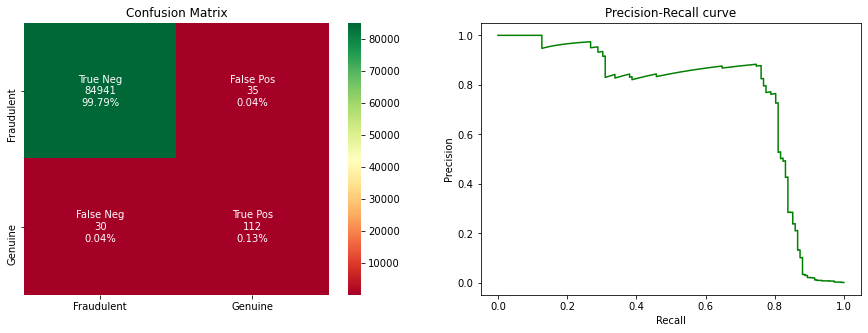

<Figure size 432x288 with 0 Axes>

In [147]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_rf_tun, y_pred_proba_rf_tun, model_rf_tun)

Embora usualmente um modelo com tunning nos hiperparâmetros performe melhor que o modelo default, esse não foi o caso aqui. A Recall aumentou de 0.75 para 0.79, no entanto a área sob a curva Precision-Recall diminuiu de 0.82 para 0.75. Entre os dois modelos a Ranfom Forest default talvez seja o mais adequado, uma vez que a área acaba sendo uma métrica mais equilibrada, dado o nosso problema.

Vamos agora observar a importância das features nos dois modelos de Random Forest.

#### 6.2.3 A importância das features

Primeiro vamos plotar a importância das features para o modelo default - que, como dissemos acima, tem uma perfomance melhor em comparação ao modelo com os parâmetros ajustados que escolhemos. Será que ambos os modelos dão o mesmo peso para as variáveis ao longo do procedimento? Vamos ver.

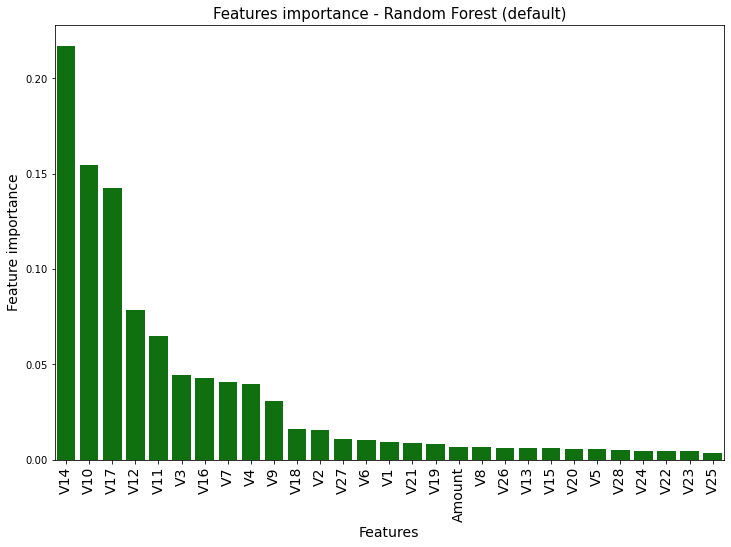

In [185]:
plt.figure(figsize = (12,8))
# Lista de variáveis
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
            'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Construindo um data frame, ordenando por importância da variável, da maior para a menor
features_import_rf = pd.DataFrame({'Feature': features, 'Feature importance': model_rf.feature_importances_})
features_import_rf = features_import_rf.sort_values(by='Feature importance', ascending=False)

# Plotando um barplot
g = sns.barplot(x='Feature', y='Feature importance', data=features_import_rf, color='g')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=14)
g.set_ylabel('Feature importance', fontsize=14)
g.set_xlabel('Features', fontsize=14)
g.set_title('Features importance - Random Forest (default)', fontsize=15)
plt.show() 

Na sequência repetimos o processo mas agora para o modelo com os hiperparâmetros tunados. 

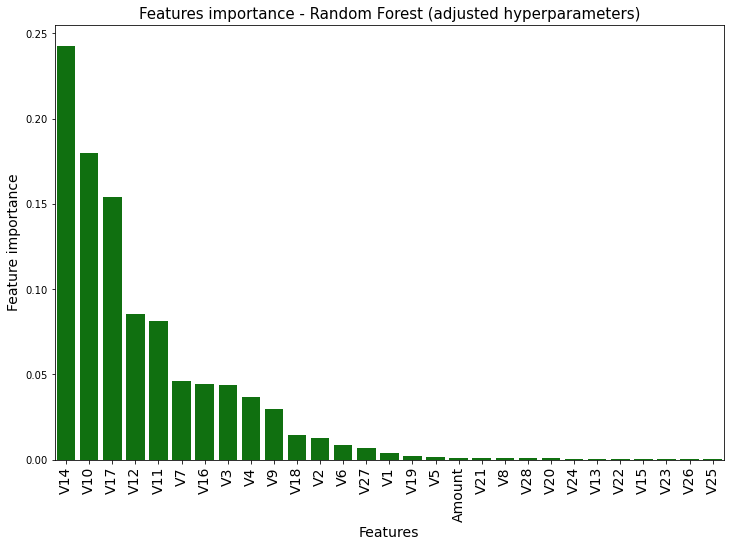

In [184]:
plt.figure(figsize = (12,8))
# Lista de variáveis
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
            'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Construindo um data frame, ordenando por importância da variável, da maior para a menor
features_import_rf_tun = pd.DataFrame({'Feature': features, 'Feature importance': model_rf_tun.feature_importances_})
features_import_rf_tun = features_import_rf_tun.sort_values(by='Feature importance', ascending=False)

# Plotando um barplot
g = sns.barplot(x='Feature', y='Feature importance', data=features_import_rf_tun, color='g')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=14)
g.set_ylabel('Feature importance', fontsize=14)
g.set_xlabel('Features', fontsize=14)
g.set_title('Features importance - Random Forest (adjusted hyperparameters)', fontsize=15)
plt.show() 

Como vemos, novamente a feature "V14" aparece como tendo um impacto grande sobre o modelo, assim como ocorreu na Regressão Logística e também na nossa análise inicial das correlações. Já a variável "V10", embora não tenha aparecido na análise das correlações, aparece como sendo importante tanto aqui quanto na Regressão. Já a variável "V17" aparece tendo uma importância grande nos resultados da Random Forest, concordando com análise exploratória que fizemos. 

Se compararmos os dois plots de importância acima, é possível ver que no modelo tunado as primeiras features possuem um valor superior (um peso maior nas decisões) se comparadas ao plot default. Também se vê que as demais features possuem um impacto quase nulo no caso tunado.

Por fim, o último modelo que iremos trabalhar será o XGBoost Classifier. 

### 6.3) XGBooost Classifier

Agora vamos explorar o modelo de XGBoost Classifier. Esse tipo de técnica têm sido muito poderosa recentemente em muitas competições no Kaggle. É um modelo que combina as árvores de decisão junto com a técnica de Gradient Boosting, que é uma espécie de melhora no aprendizado modelo atráves dos erros dos passos anteriores. Não iremos nos aprofundar nos detalhes aqui.

Abaixo segue os resultados do modelo de base.

#### 6.3.1 Modelo de Base

In [160]:
# Instanciando o classificador
model_xgb_clf = xgb.XGBClassifier(random_state = 42)

# Construindo a pipeline 
pipeline_xgb = Pipeline([('smote', smote), ('model_xgb_clf', model_xgb_clf)])

# Treinando o modelo
pipeline_xgb.fit(X_train, y_train)

# Realizando as previsões
y_pred_xgb = pipeline_xgb.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[22:49:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [161]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, model_xgb_clf)

Avaliando o modelo de base para a métrica F2 : 0.79
Avaliando o modelo de base para a métrica Precision : 0.84
Avaliando o modelo de base para a métrica Recall : 0.77
Avaliando o modelo de base para a métrica AUC-PR : 0.80


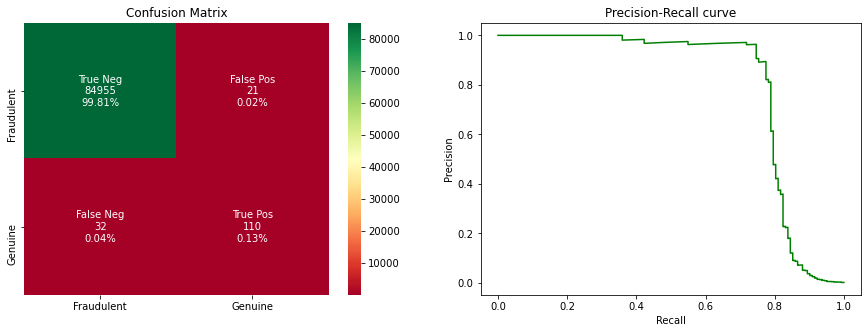

<Figure size 432x288 with 0 Axes>

In [162]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_xgb, y_pred_proba_xgb, model_xgb_clf)

Como se vê, embora o Recall tenha aumentado ligeiramente se comparado ao caso de Random Forest default, a área sob a curva Precision-Recall diminuiu de 0.82 para 0.80 comparando os dois casos. A F2 se manteve estável. Novamente, é difícil estabelecer se um modelo é melhor do que o outro uma vez que os resultados quase não variam muito. Acredito que isso ocorra devido ao enorme desbalanceamento dos dados, o que necessitaria de uma combinação de modelos (ensemble) de modo mais elaborado de tal forma a melhorar as métricas. 

Vamos observar a performance do modelo com os parâmetros tunados.

#### 6.3.2 Modelo com tuning nos hiperparâmetros

Começamos definindo qual é o nosso grid de parâmetros a serem ajustados. Os parâmetros que escolhemos são: 1) max_depth: profundidade máxima das árvores, igual na Random Forest; 2) learning_rate: especifíca o quão rápido o modelo fita os erros residuais; 3) gamma e reg_lambda: especificam qual o método de regularização será usado; 4) subsample: fração dos dados de treino que serão usados para treinar cada árvore; 5) colsample_bytree: fração de features que são usadas para treinar cada árvore. 

Segue então o grid que definimos.

In [168]:
param_grid = {
    "model_xgb_clf__max_depth": [5, 7],
    "model_xgb_clf__learning_rate": [0.1, 0.01, 0.05],
    "model_xgb_clf__gamma": [0, 0.5, 1],
    "model_xgb_clf__reg_lambda": [0, 1, 10],
    "model_xgb_clf__subsample": [0.8],
    "model_xgb_clf__colsample_bytree": [0.5],
}

In [169]:
# Iniciando o RandomSearch
CV_model_xgb = RandomizedSearchCV(estimator = pipeline_xgb, param_distributions = param_grid, n_jobs=-1, cv=3, scoring="recall")

In [170]:
# Treinando o modelo nos dados
CV_model_xgb.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(random_state=42,
                                                    sampling_strategy=0.15)),
                                             ('model_xgb_clf',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            enable_categorical=False,
                                                            gamma=0, gpu_id=-1,
                                                            importance_type=None,
                                                            interac

In [171]:
# Obtendo a melhor combinação de hiperparâmetros
CV_model_xgb.best_params_

{'model_xgb_clf__subsample': 0.8,
 'model_xgb_clf__reg_lambda': 0,
 'model_xgb_clf__max_depth': 5,
 'model_xgb_clf__learning_rate': 0.05,
 'model_xgb_clf__gamma': 0,
 'model_xgb_clf__colsample_bytree': 0.5}

Vamos usar esses valores para testar o modelo e ver se ele performa melhor que o modelo default. 

In [172]:
# Instanciando o classificador
model_xgb_clf_tun = xgb.XGBClassifier(subsample = 0.8, reg_lambda = 0, max_depth = 5, learning_rate = 0.05, gamma = 0,
                                      colsample_bytree = 0.5, random_state = 42)

# Construindo a pipeline 
pipeline_xgb_tun = Pipeline([('smote', smote), ('model_xgb_clf', model_xgb_clf_tun)])

# Treinando o modelo
pipeline_xgb_tun.fit(X_train, y_train)

# Realizando as previsões
y_pred_xgb_tun = pipeline_xgb_tun.predict(X_test)

# Prevendo probabilidades 
y_pred_proba_xgb_tun = pipeline_xgb_tun.predict_proba(X_test)[:, 1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [173]:
# Avaliando o modelo de base utilizando a função evaluate_model
evaluate_model(y_test, y_pred_xgb_tun, y_pred_proba_xgb_tun, model_xgb_clf_tun)

Avaliando o modelo de base para a métrica F2 : 0.76
Avaliando o modelo de base para a métrica Precision : 0.64
Avaliando o modelo de base para a métrica Recall : 0.80
Avaliando o modelo de base para a métrica AUC-PR : 0.80


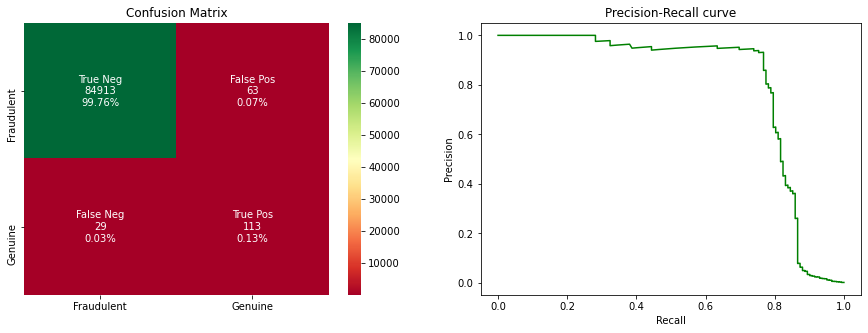

<Figure size 432x288 with 0 Axes>

In [174]:
# Plotando a matriz de confusão e a curva Precision-Recall
plot_confusion_PR(y_test, y_pred_xgb_tun, y_pred_proba_xgb_tun, model_xgb_clf_tun)

Se compararmos os dois modelos de XGBoost, ambos possuem a mesma área sob a curva Precision-Recall, porém, o modelo com tuning nos hiperparâmetros possui um Recall superior, de 0.77 para 0.80. No entanto, a Precision do modelo com tuning é excessivamente inferior ao modelo default. Desse modo, entre esses dois modelos, assim como no caso de Random Forest, aparentemente o modelo default performou melhor. 

Vamos analisar a importância das features para ambos os casos.

#### 6.3.3 A importância das features

Iniciando pelo caso com todos hiperparâmetros como default.

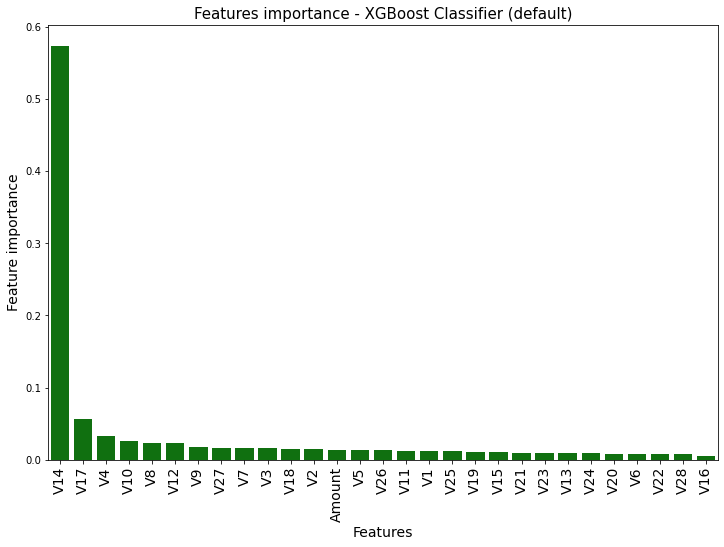

In [183]:
plt.figure(figsize = (12,8))
# Lista de variáveis
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
            'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Construindo um data frame, ordenando por importância da variável, da maior para a menor
features_import_xgb = pd.DataFrame({'Feature': features, 'Feature importance': model_xgb_clf.feature_importances_})
features_import_xgb = features_import_xgb.sort_values(by='Feature importance', ascending=False)

# Plotando um barplot
g = sns.barplot(x='Feature', y='Feature importance', data=features_import_xgb, color='g')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=14)
g.set_ylabel('Feature importance', fontsize=14)
g.set_xlabel('Features', fontsize=14)
g.set_title('Features importance - XGBoost Classifier (default)', fontsize=15)
plt.show() 

E agora o caso com os hiperparâmetros ajustados.

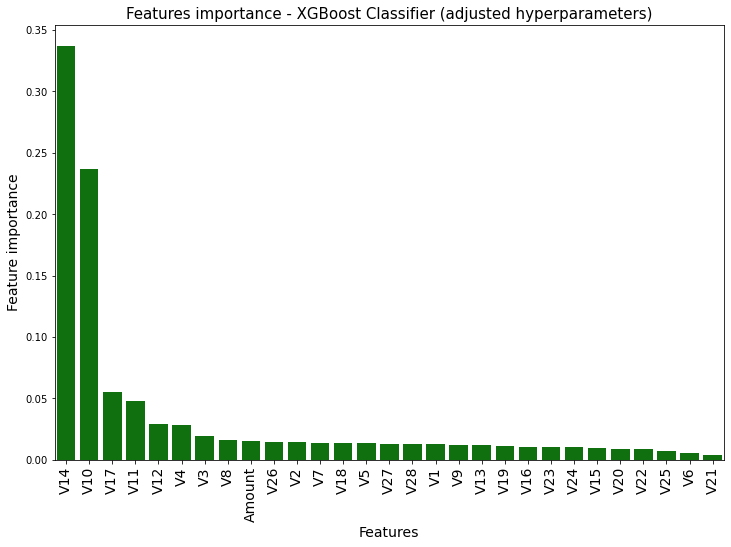

In [182]:
plt.figure(figsize = (12,8))
# Lista de variáveis
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
            'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Construindo um data frame, ordenando por importância da variável, da maior para a menor
features_import_xgb = pd.DataFrame({'Feature': features, 'Feature importance': model_xgb_clf_tun.feature_importances_})
features_import_xgb = features_import_xgb.sort_values(by='Feature importance', ascending=False)

# Plotando um barplot
g = sns.barplot(x='Feature', y='Feature importance', data=features_import_xgb, color='g')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=14)
g.set_ylabel('Feature importance', fontsize=14)
g.set_xlabel('Features', fontsize=14)
g.set_title('Features importance - XGBoost Classifier (adjusted hyperparameters)', fontsize=15)
plt.show() 

Nota-se, mais uma vez, a presença das variáveis "V14", "V10" e "V17" como as três variáveis que mais são importantes na previsão do target. Dessas, a variável "V14" foi a que teve mais "impacto" nos três modelos e também era a que atingia a maior correlação negativa com o alvo na análise exploratória de dados. 


Quanto os dois plots acima, percebe-se que no caso default a importância das variável "V14" se sobrepõe a todas as outras. Ela praticamente domina completamente o modelo. No caso com tuning a variável "V10" passa a ter um grau de importância maior. No entanto, as duas também dominam completamente sobre as demais. 

## 7) Conclusões

Adicionar as conclusões do trabalho